#### Notebook setup

In [1]:
import time
import warnings
import os, sys
from copy import deepcopy
from types import SimpleNamespace
from pprint import pprint as print

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange

from multirotor.helpers import control_allocation_matrix, DataLog
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from multirotor.controller import (
    PosController, VelController,
    AttController, RateController,
    AltController, AltRateController,
    Controller
)
from multirotor.simulation import Multirotor, Propeller, Motor, Battery
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from multirotor.env import SpeedsMultirotorEnv, DynamicsMultirotorEnv
from multirotor.trajectories import Trajectory
from multirotor.visualize import plot_datalog
from multirotor.optimize import optimize, DEFAULTS, run_sim, apply_params

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent

/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Parameters

In [2]:
# Tarot T18 params
bp = BatteryParams(max_voltage=22.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    # resistance=0.27,
    resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0347,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=mp
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi,
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.01, g=9.81)

### Multirotor

Simulating individual components of the multirotor. These make up the final `Multirotor` object.

#### Motor

Text(0.5, 0, 'Time /ms')

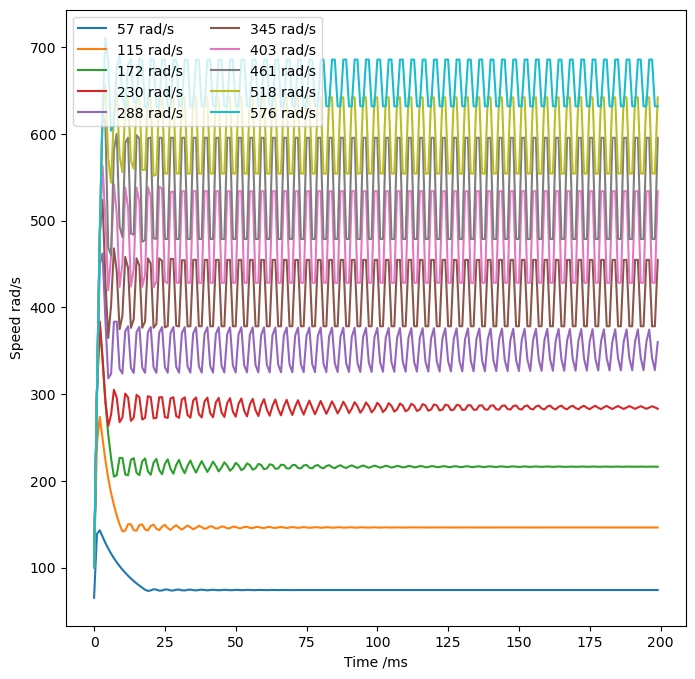

In [3]:
%matplotlib inline
# Plot motor speeds as a function of time and input voltage signal
plt.figure(figsize=(8,8))
motor = Motor(mp, sp)
for vsignal in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    speeds = []
    motor.reset()
    speed = vsignal / mp.speed_voltage_scaling
    for i in range(200):
        speeds.append(motor.step(speed))
    plt.plot(speeds, label='%d rad/s' % speed)
plt.legend(ncol=2)
plt.ylabel('Speed rad/s')
plt.xlabel('Time /ms')

Learning a linear relationship for the equation $V = k_{scaling} * speed$ for motors. This is useful for `SpeedsMultirotorEnv` which takes speed signals as the input. This constant converts speeds to applied voltages. The default value in`MotorParams` is 1, meaning the actions are voltage signals.

In [4]:
from multirotor.helpers import learn_speed_voltage_scaling

def make_motor_fn(params, sp):
    from copy import deepcopy
    params = deepcopy(params)
    params.speed_voltage_scaling = 1.
    def motor_step(signal):
        m = Motor(params, sp)
        for i in range(100):
            s = m.step(signal)
        return s
    return motor_step

print('Voltage = %.5f * speed' % (learn_speed_voltage_scaling(make_motor_fn(mp, sp))))

'Voltage = 0.02862 * speed'


#### Propeller

The propeller can use a numerically solved thrust relationship, where thrust depends on airspeed. Or the easier option of using thrust coefficient is available.

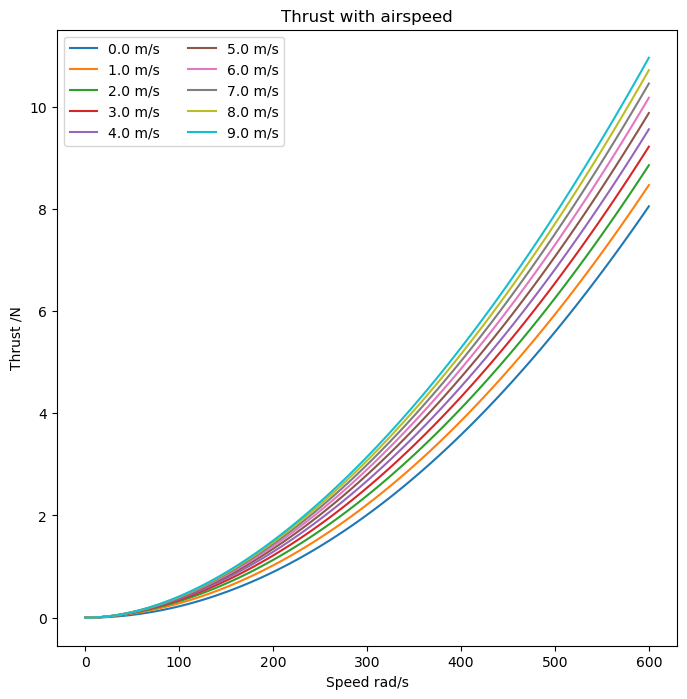

In [5]:
%matplotlib inline
# Plot propeller speed by numerically solving the thrust equation,
# *if* accurate propeller measurements are given in params
pp_ = deepcopy(pp)
pp_.use_thrust_constant = False # Set to true to just use k_thrust
prop = Propeller(pp_, sp)
plt.figure(figsize=(8,8))
speeds = np.linspace(0, 600, num=100)
for a in np.linspace(0, 10, 10, endpoint=False):
    thrusts = []
    for s in speeds:
        thrusts.append(prop.thrust(s, np.asarray([0, 0, a])))
    plt.plot(speeds, thrusts, label='%.1f m/s' % a)
plt.xlabel('Speed rad/s')
plt.ylabel('Thrust /N')
plt.title('Thrust with airspeed')
plt.legend(ncol=2)

#### Vehicle

Create a `Multirotor` object, given `VehicleParams` and `SimulationParams`

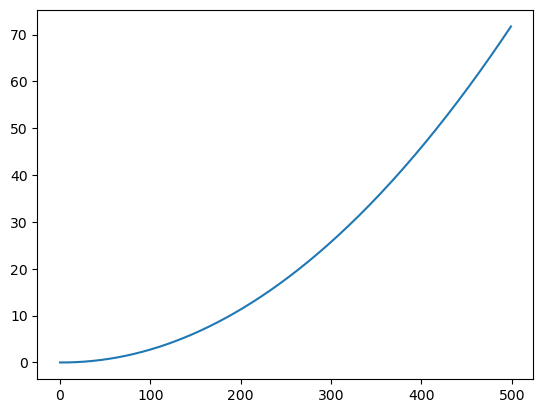

In [6]:
# Combine propeller/motor/vehicle to get vehicle.
# Take off simulation
m = Multirotor(vp, sp)
log = DataLog(vehicle=m) # convenient logging class
m.reset()
m.state *= 0 # set to zero, reset() sets random values
action = m.allocate_control( # In this case action is allocated speed signals
    thrust=m.weight * 1.1,
    torques=np.asarray([0, 0, 0])
)
for i in range(500):
    m.step_speeds(action)
    log.log()
log.done_logging()
plt.plot(log.z)

In [7]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [19]:
best_agent = PIDAgent()
best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000}
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
references = []
errors = []
speeds = []

def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("sliding", params, wind_ranges, nasa_wp, start_alt=30, has_turbulence=False)
    params = env.base_env.ctrl.get_params()
    params['ctrl_p']['max_velocity'] = 15
    params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)
    # params['ctrl_v']['k_i'] = params['ctrl_v']['k_p'] * 10# / 10
    
    env.base_env.ctrl.set_params(**params)
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        errors.append([env.base_env.ctrl.ctrl_v.err_p, env.base_env.ctrl.ctrl_v.err_i])
        # speeds.append([log.vehicle.speeds])
        speeds.append([env.base_env.vehicle.speeds])
        
        
        # references.append(log.c)

    log.done_logging()
    return log, info, np.array(errors), np.array(speeds)

log, info, errors, speeds = run_trajectory(env_selector, [(12,12), (0,0), (0,0)], best_agent, best_params)

In [9]:
speeds.shape

(10037, 1, 8)

In [25]:
np.count_nonzero(speeds[:,:,0] == speeds[:,:,1])

10734

In [26]:
np.count_nonzero(speeds[:,:,0] != speeds[:,:,1])

20226

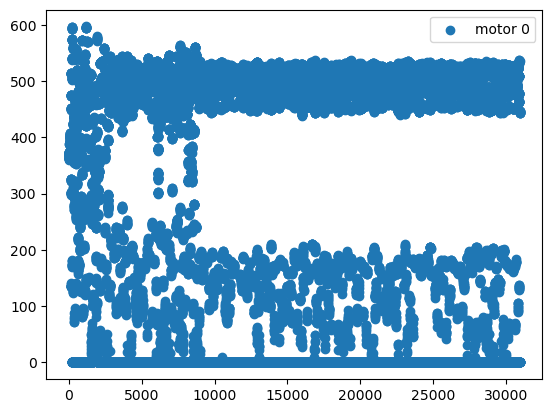

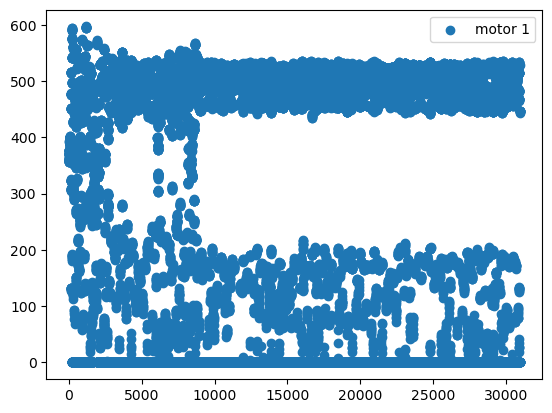

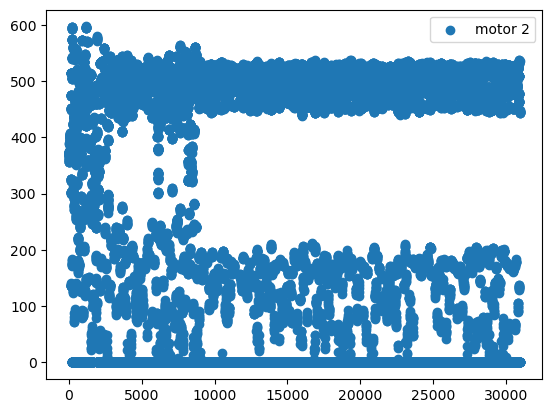

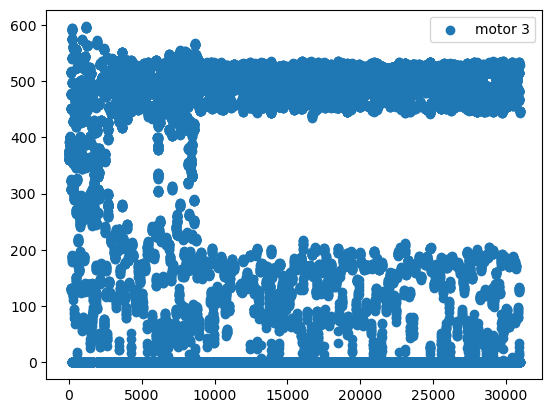

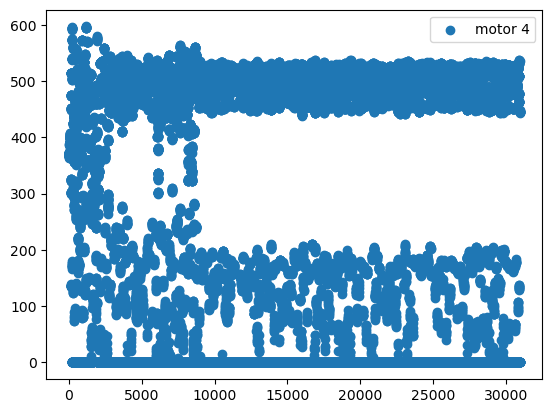

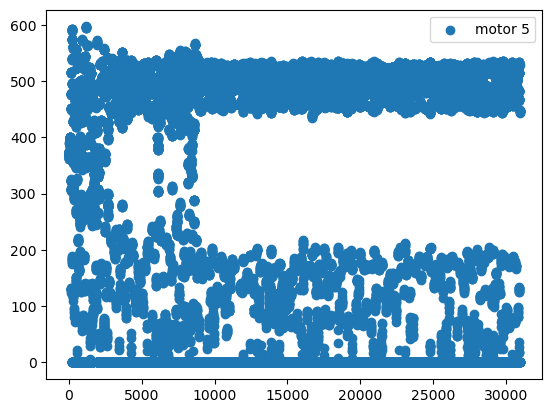

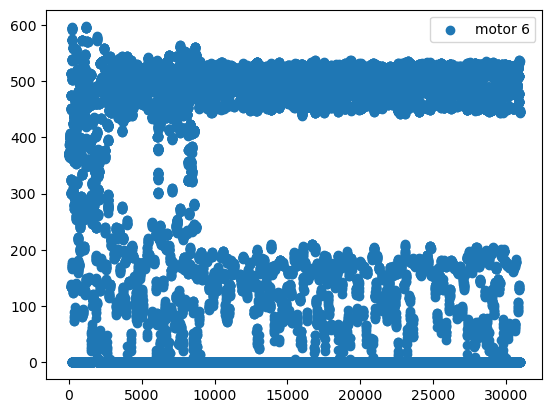

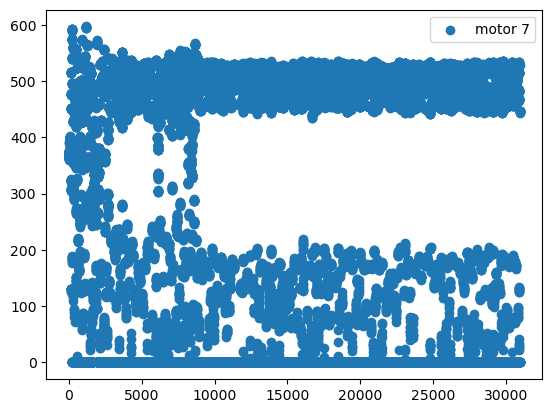

In [20]:
for i in range(8):
    plt.scatter(list(range(len(speeds))), speeds.squeeze()[:,i], label=f'motor {i}')
    plt.legend()
    plt.show()

In [9]:
errors.shape

(621, 2, 2)

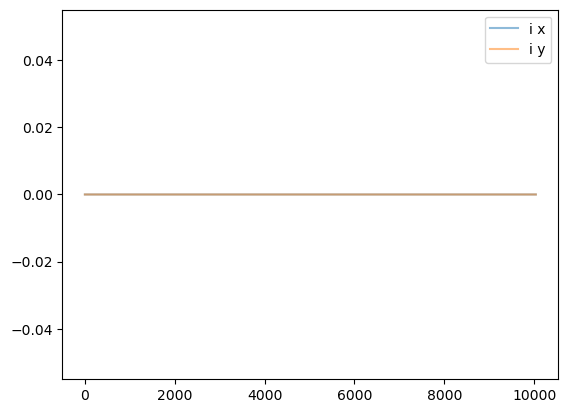

In [14]:
# plt.plot(errors[:,0,0], label='p x')
# plt.plot(errors[:,0,1], label='p y')
plt.plot(errors[:,1,0], label='i x', alpha=0.5)
plt.plot(errors[:,1,1], label='i y', alpha=0.5)
plt.legend()

In [11]:
env = env_selector.get_env("sliding", best_params, [(0,0),(0,0),(0,0)], square_wpts, start_alt=30, has_turbulence=False)
params = env.base_env.ctrl.get_params()
print(params)

{'ctrl_a': {'k_d': array([0., 0., 0.]),
            'k_i': array([0., 0., 0.]),
            'k_p': array([2., 2., 2.]),
            'max_acceleration': 0.2,
            'max_err_i': array(1.),
            'max_jerk': 100.0,
            'square_root_scaling': False},
 'ctrl_p': {'k_d': array([0., 0.]),
            'k_i': array([0., 0.]),
            'k_p': array([0.38, 0.38]),
            'leashing': False,
            'max_acceleration': 3.0,
            'max_err_i': array(1.),
            'max_jerk': 100.0,
            'max_velocity': 15,
            'square_root_scaling': False},
 'ctrl_r': {'k_d': array([0., 0., 0.]),
            'k_i': array([0., 0., 0.]),
            'k_p': array([10., 10., 10.]),
            'max_acceleration': array([8.3891751 , 8.3891751 , 0.35866418]),
            'max_err_i': array(0.5)},
 'ctrl_v': {'k_d': array([0., 0.]),
            'k_i': array([0., 0.]),
            'k_p': array([0.08, 0.08]),
            'max_err_i': array(3.),
            'max_tilt': 0

In [ ]:
params

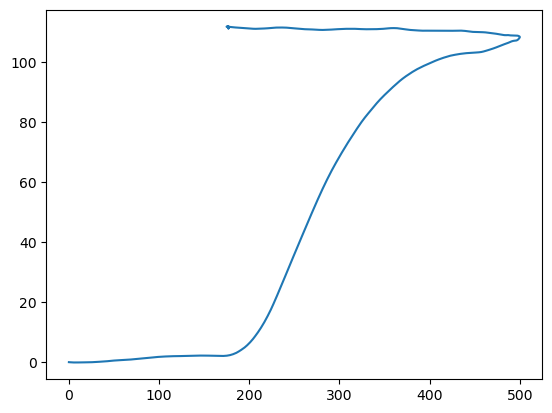

In [18]:
plt.plot(log.x, log.y)

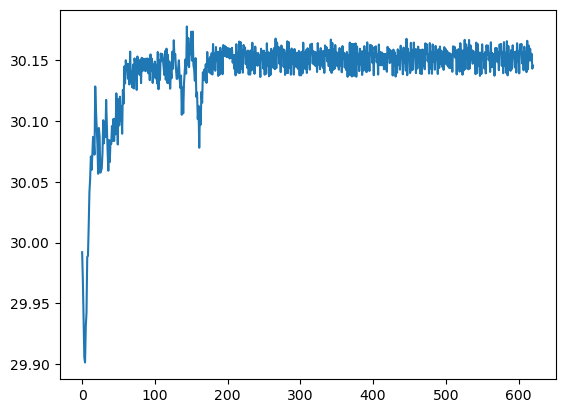

In [28]:
plt.plot(log.z)

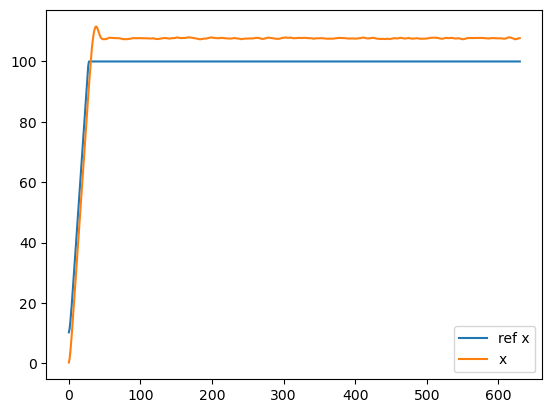

In [16]:
plt.plot(log.target.position[:,0], label='ref x')
plt.plot(log.position[:,0], label='x')
# plt.plot(log.target.position[:,0], label='ref y')
# plt.plot(log.position[:,1], label='y')
# plt.ylim(95, 105)
plt.legend()

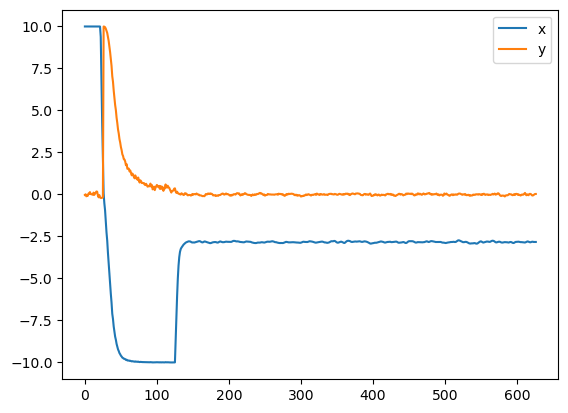

In [25]:
plt.plot(log.target.velocity[:,0], label='x')
plt.plot(log.target.velocity[:,1], label='y')
plt.legend()

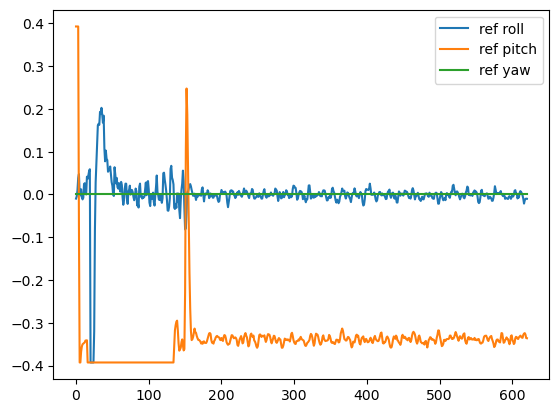

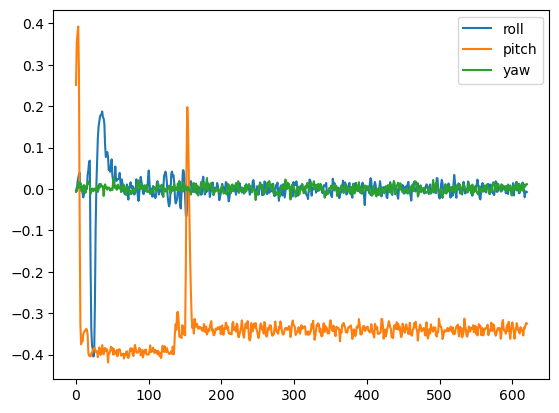

In [11]:
plt.plot(log.target.orientation[:,0], label='ref roll')
plt.plot(log.target.orientation[:,1], label='ref pitch')
plt.plot(log.target.orientation[:,2], label='ref yaw')
plt.legend()
plt.show()

plt.plot(log.orientation[:,0], label='roll')
plt.plot(log.orientation[:,1], label='pitch')
plt.plot(log.orientation[:,2], label='yaw')
plt.legend()
plt.show()

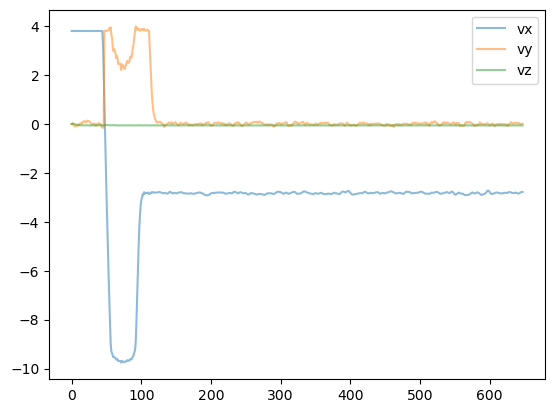

In [21]:
plt.plot(log.target.velocity[:,0], label='vx', alpha=0.5)
plt.plot(log.target.velocity[:,1], label='vy', alpha=0.5)
plt.plot(log.target.velocity[:,2], label='vz', alpha=0.5)
plt.legend()

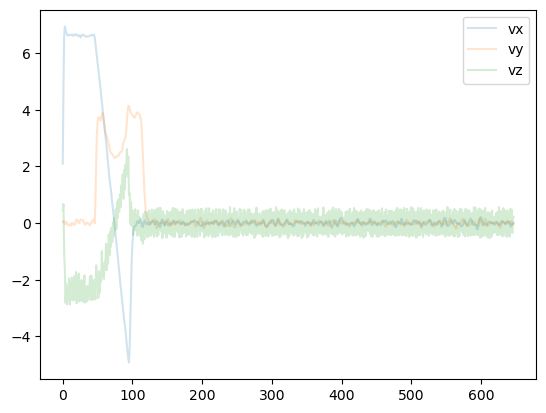

In [19]:
plt.plot(log.velocity[:,0], label='vx', alpha=0.2)
plt.plot(log.velocity[:,1], label='vy', alpha=0.2)
plt.plot(log.velocity[:,2], label='vz', alpha=0.2)
plt.legend()

### PID Controller

This section explains how a PID controller is constructed. This is a cascaded PID architecture. See `Controller` docs
for more details.

In [481]:
# From PID parameters file
def get_controller(m: Multirotor, max_velocity=5., max_acceleration=3.):
    assert m.simulation.dt <= 0.1, 'Simulation time step too large.'
    pos = PosController(
        1.0, 0., 0., 1., vehicle=m,
        max_velocity=max_velocity, max_acceleration=max_acceleration,
        square_root_scaling=False, leashing=True
    )
    vel = VelController(
        2.0, 1.0, 0.5,
        max_err_i=max_acceleration,
        max_tilt=np.pi/12,
        vehicle=m)
    att = AttController(
        [2.6875, 4.5, 4.5],
        0, 0.,
        max_err_i=1.,
        vehicle=m)
    rat = RateController(
        [4., 4., 4.],
        0, 0,
        max_err_i=0.5,
        max_acceleration=1.,
        vehicle=m)
    alt = AltController(
        1, 0, 0,
        max_err_i=1, vehicle=m,
        max_velocity=1)
    alt_rate = AltRateController(
        5, 0, 0,
        max_err_i=1, vehicle=m)
    ctrl = Controller(
        pos, vel, att, rat, alt, alt_rate,
        period_p=0.1, period_a=0.01, period_z=0.1
    )
    return ctrl

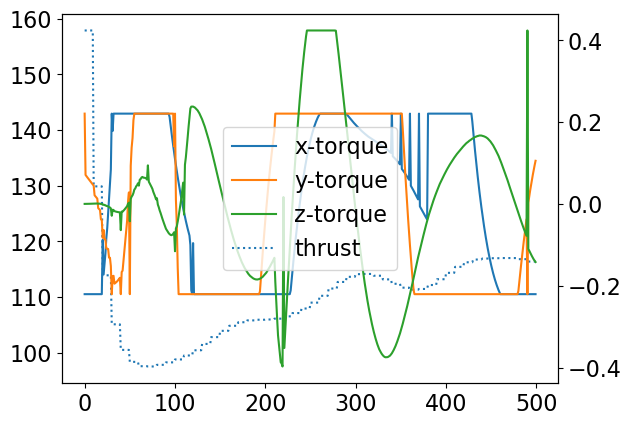

In [11]:
%matplotlib inline
m = Multirotor(vp, sp)
ctrl = get_controller(m)
log = DataLog(vehicle=m, controller=ctrl)
for i in range(500):
    action = ctrl.step((0.01,0.1,1,0))
    # no allocation or motor simulation, for which we first need to
    # m.step_speeds(m.allocate_control(action[0], action[3:])
    # Instead, requested dynamics are fulfilled:
    dynamics = np.zeros(6, m.dtype)
    dynamics[2] = action[0]
    dynamics[3:] = action[1:]
    m.step_dynamics(dynamics)
    log.log()
log.done_logging()

plt.plot(log.actions[:,0], ls=':', label='thrust')
lines = plt.gca().lines
plt.twinx()
for s, axis in zip(log.actions.T[1:], ('x','y','z')):
    plt.plot(s, label=axis + '-torque')
plt.legend(handles=plt.gca().lines + lines)

# Tuning PID Controller Parameters Manually

In [482]:
ctrl = get_controller(m)

In [3]:
env_selector = OctorotorEnvSelector()

In [4]:
env = env_selector.get_env("sliding", best_params, [(7,7), (0,0), (0,0)], square_wpts, start_alt=30, has_turbulence=False)
ctrl = env.base_env.ctrl

NameError: name 'best_params' is not defined

In [50]:
optimal_params = ctrl.get_params()

In [51]:
optimal_params

{'ctrl_p': {'k_p': array([1.000, 1.000]),
  'k_i': array([0.000, 0.000]),
  'k_d': array([0.000, 0.000]),
  'max_err_i': array(1.000),
  'max_velocity': 5.0,
  'max_acceleration': 3.0,
  'max_jerk': 100.0,
  'square_root_scaling': False,
  'leashing': False},
 'ctrl_v': {'k_p': array([2.000, 2.000]),
  'k_i': array([1.000, 1.000]),
  'k_d': array([0.500, 0.500]),
  'max_err_i': array(3.000),
  'max_tilt': 0.2617993877991494},
 'ctrl_a': {'k_p': array([2.688, 4.500, 4.500]),
  'k_i': array([0.000, 0.000, 0.000]),
  'k_d': array([0.000, 0.000, 0.000]),
  'max_err_i': array(1.000),
  'max_acceleration': 0.2,
  'max_jerk': 100.0,
  'square_root_scaling': False},
 'ctrl_r': {'k_p': array([4.000, 4.000, 4.000]),
  'k_i': array([0.000, 0.000, 0.000]),
  'k_d': array([0.000, 0.000, 0.000]),
  'max_err_i': array(0.500),
  'max_acceleration': 1.0},
 'ctrl_z': {'k_p': array(1.000),
  'k_i': array([0.000]),
  'k_d': array([0.000]),
  'max_err_i': array(1.000),
  'max_velocity': 5.0},
 'ctrl_vz': {

In [45]:
optimal_params['ctrl_p']['k_i'] = np.array([100,100])

In [483]:
ctrl.set_params(**optimal_params)

#### Attitude Rate Controller

In [77]:
optimal_params = ctrl.get_params()

In [81]:
optimal_params

{'ctrl_p': {'k_p': array([5.853, 5.853]),
  'k_i': array([1.248, 1.248]),
  'k_d': array([98.380, 98.380]),
  'max_err_i': array(1.000),
  'max_velocity': 5.0,
  'max_acceleration': 3.0,
  'max_jerk': 100.0,
  'square_root_scaling': False,
  'leashing': False},
 'ctrl_v': {'k_p': array([20.381, 20.381]),
  'k_i': array([3.883, 3.883]),
  'k_d': array([18.547, 18.547]),
  'max_err_i': array(3.000),
  'max_tilt': 0.2617993877991494},
 'ctrl_a': {'k_p': array([27.471, 27.471, 1.736]),
  'k_i': array([2.738, 2.738, 0.485]),
  'k_d': array([23.700, 23.700, 20.797]),
  'max_err_i': array(1.000),
  'max_acceleration': 0.2,
  'max_jerk': 100.0,
  'square_root_scaling': False},
 'ctrl_r': {'k_p': array([27.895, 27.895, 3.780]),
  'k_i': array([0, 0, 0]),
  'k_d': array([0, 0, 0]),
  'max_err_i': array(0.500),
  'max_acceleration': array([8.389, 8.389, 0.359])},
 'ctrl_z': {'k_p': array(1.000),
  'k_i': array([0.000]),
  'k_d': array([0.000]),
  'max_err_i': array(1.000),
  'max_velocity': 5.0},

In [217]:
optimal_params['ctrl_a']['k_p'] = np.array([2, 2, 2])
# optimal_params['ctrl_a']['k_p'] = np.array([2.68,0, 0])
optimal_params['ctrl_a']['k_i'] = np.array([0,0,0])
optimal_params['ctrl_a']['k_d'] = np.array([0,0,0])

In [218]:
optimal_params['ctrl_r']['k_p'] = np.array([10, 10, 10])
# optimal_params['ctrl_r']['k_p'] = np.array([4, 0, 0])
optimal_params['ctrl_r']['k_i'] = np.array([0,0,0])
optimal_params['ctrl_r']['k_d'] = np.array([0,0,0])

In [219]:
ctrl.set_params(**optimal_params)

In [214]:
# import pickle 

# with open('best_trial_v2.pkl', 'rb') as f:
#     best_trial = pickle.load(f)

In [215]:
# ctrl.set_params(**apply_params(None, params=best_trial.params))

# Roll (Rate Controller)

RateController(k_p=array([10.000, 0.000, 0.000]),
               k_i=array([0.000, 0.000, 0.000]),
               k_d=array([0.000, 0.000, 0.000]),
               max_err_i=array(0.500),
               vehicle=<multirotor.simulation.Multirotor object at 0x7fa8ddfdfaf0>,
               max_acceleration=array([8.389, 8.389, 0.359]))
AttController(k_p=array([2.000, 0.000, 0.000]),
              k_i=array([0.000, 0.000, 0.000]),
              k_d=array([0.000, 0.000, 0.000]),
              max_err_i=array(1.000),
              vehicle=<multirotor.simulation.Multirotor object at 0x7fa8ddfdfaf0>,
              max_acceleration=0.2,
              max_jerk=100.0,
              square_root_scaling=False)


Text(0.5, 1.0, 'Ref orientation[0.393 0.000 0.000]')

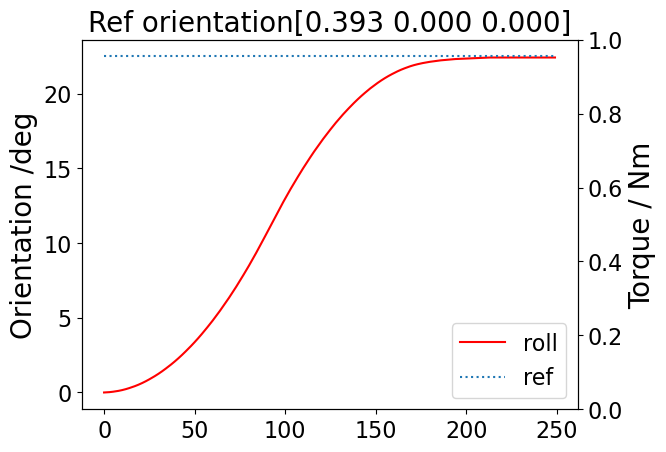

In [216]:
m = Multirotor(vp, sp)
fz = m.weight
rat = ctrl.ctrl_r
print(rat)
att = ctrl.ctrl_a
print(att)
log = DataLog(vehicle=m, controller=ctrl, other_vars=('err',))
for i in range(250):
    ref = np.asarray([0.3926991, 0, 0])
    rate = att.step(ref, m.orientation, m.simulation.dt)
    torque = rat.step(rate, m.euler_rate, m.simulation.dt)
    action = np.clip(torque, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, 0, *action]))
    log.log(err=rat.err_p[0])
    log._actions[-1] = action
log.done_logging()

plt.plot(log.roll * 180 / np.pi, c='r', label='roll')
plt.plot([ref[0] * 180 / np.pi]*250, ls=':', label='ref')
# plt.plot(log.pitch * 180 / np.pi, c='g', label='pitch')
# plt.plot(log.yaw * 180 / np.pi, c='b', label='yaw')
plt.ylabel('Orientation /deg')
plt.legend()
plt.twinx()
# plt.plot(log.actions[:,0], ls=':', c='r')
# plt.plot(log.actions[:,1], ls=':', c='g')
# plt.plot(log.actions[:,2], ls=':', c='b')
plt.ylabel('Torque / Nm')
plt.title('Ref orientation' + str(ref))

#### Altitude Controller

In [400]:
optimal_params = ctrl.get_params()

In [413]:
optimal_params

{'ctrl_p': {'k_p': array([0.380, 0.380]),
  'k_i': array([0.000, 0.000]),
  'k_d': array([0.000, 0.000]),
  'max_err_i': array(1.000),
  'max_velocity': 5.0,
  'max_acceleration': 3.0,
  'max_jerk': 100.0,
  'square_root_scaling': False,
  'leashing': False},
 'ctrl_v': {'k_p': array([0.080, 0.080]),
  'k_i': array([0.000, 0.000]),
  'k_d': array([0.000, 0.000]),
  'max_err_i': array(3.000),
  'max_tilt': 0.2617993877991494},
 'ctrl_a': {'k_p': array([2.000, 2.000, 2.000]),
  'k_i': array([0.000, 0.000, 0.000]),
  'k_d': array([0.000, 0.000, 0.000]),
  'max_err_i': array(1.000),
  'max_acceleration': 0.2,
  'max_jerk': 100.0,
  'square_root_scaling': False},
 'ctrl_r': {'k_p': array([10.000, 10.000, 10.000]),
  'k_i': array([0.000, 0.000, 0.000]),
  'k_d': array([0.000, 0.000, 0.000]),
  'max_err_i': array(0.500),
  'max_acceleration': array([8.389, 8.389, 0.359])},
 'ctrl_z': {'k_p': array([0.100]),
  'k_i': array([0.100]),
  'k_d': array([0.100]),
  'max_err_i': array(1.000),
  'max_

In [457]:
optimal_params['ctrl_z']['k_p'] = np.array([0.1])
optimal_params['ctrl_z']['k_i'] = np.array([0.05])
optimal_params['ctrl_z']['k_d'] = np.array([0.01])
optimal_params['ctrl_z']['max_velocity'] = np.array([1])

z_params = optimal_params['ctrl_z']

In [412]:
optimal_params['ctrl_z']['k_p']

array([0.100])

In [404]:
optimal_params['ctrl_vz']['k_p'] = np.array([5])
optimal_params['ctrl_vz']['k_i'] = np.array([0])
optimal_params['ctrl_vz']['k_d'] = np.array([0])

In [458]:
ctrl.set_params(**optimal_params)

AltController(k_p=array([0.100]),
              k_i=array([0.050]),
              k_d=array([0.010]),
              max_err_i=array(1.000),
              vehicle=<multirotor.simulation.Multirotor object at 0x7fa8ddfdfaf0>,
              max_velocity=array([1]))
AltRateController(k_p=array([5]),
                  k_i=array([0]),
                  k_d=array([0]),
                  max_err_i=array(1),
                  vehicle=<multirotor.simulation.Multirotor object at 0x7fa8ddfdfaf0>)


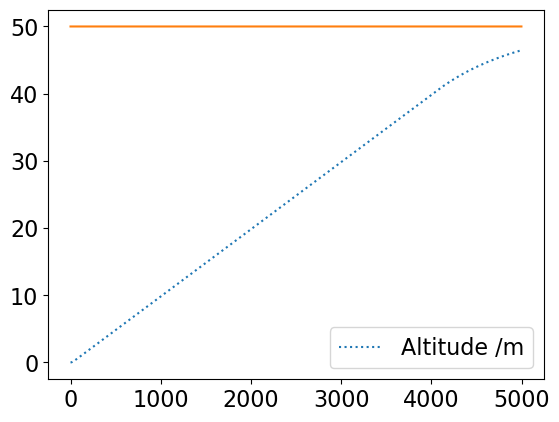

In [459]:
m = Multirotor(vp, sp)
alt = ctrl.ctrl_z
# print(alt)
alt.set_params(**z_params)
print(alt)
alt_rate = ctrl.ctrl_vz
print(alt_rate)
log = DataLog(vehicle=m, other_vars=('thrust',))
for i in range(5000):
    ref = np.asarray([50.])
    rate = alt.step(ref, m.position[2:], dt=0.1)
    action = alt_rate.step(rate, m.inertial_velocity[2:], dt=0.1)
    action = np.clip(action, a_min=-2*m.weight, a_max=2*m.weight)
    m.step_dynamics(np.asarray([0, 0, action[0], 0,0,0]))
    log.log(thrust=action)
    #log._actions[-1] = action
log.done_logging()

# l = plt.plot(log.thrust.squeeze(), label='Thrust')
# plt.twinx()
plt.plot(log.z, ls=':', label='Altitude /m')
plt.plot([ref]*5000)
plt.legend()
# plt.legend(handles=l+plt.gca().lines)

#### Position Controller

In [237]:
ctrl.get_params()

{'ctrl_p': {'k_p': array([5.853, 5.853]),
  'k_i': array([0.000, 0.000]),
  'k_d': array([0.000, 0.000]),
  'max_err_i': array(1.000),
  'max_velocity': 5.0,
  'max_acceleration': 3.0,
  'max_jerk': 100.0,
  'square_root_scaling': False,
  'leashing': False},
 'ctrl_v': {'k_p': array([20.381, 20.381]),
  'k_i': array([0.000, 0.000]),
  'k_d': array([0.000, 0.000]),
  'max_err_i': array(3.000),
  'max_tilt': 0.2617993877991494},
 'ctrl_a': {'k_p': array([2.000, 2.000, 2.000]),
  'k_i': array([0.000, 0.000, 0.000]),
  'k_d': array([0.000, 0.000, 0.000]),
  'max_err_i': array(1.000),
  'max_acceleration': 0.2,
  'max_jerk': 100.0,
  'square_root_scaling': False},
 'ctrl_r': {'k_p': array([10.000, 10.000, 10.000]),
  'k_i': array([0.000, 0.000, 0.000]),
  'k_d': array([0.000, 0.000, 0.000]),
  'max_err_i': array(0.500),
  'max_acceleration': array([8.389, 8.389, 0.359])},
 'ctrl_z': {'k_p': array(1.000),
  'k_i': array([0.000]),
  'k_d': array([0.000]),
  'max_err_i': array(1.000),
  'max_

In [343]:
optimal_params['ctrl_p']['k_p'] = np.array([0.38, 0.38])
# optimal_params['ctrl_a']['k_p'] = np.array([2.68,0, 0])
optimal_params['ctrl_p']['k_i'] = np.array([0,0])
optimal_params['ctrl_p']['k_d'] = np.array([0,0])

In [344]:
optimal_params['ctrl_v']['k_p'] = np.array([0.08, 0.08])
# optimal_params['ctrl_r']['k_p'] = np.array([4, 0, 0])
optimal_params['ctrl_v']['k_i'] = np.array([0,0])
optimal_params['ctrl_v']['k_d'] = np.array([0,0])

In [345]:
ctrl.set_params(**optimal_params)

PosController(k_p=array([0.380, 0.380]),
              k_i=array([0.000, 0.000]),
              k_d=array([0.000, 0.000]),
              max_err_i=array(1.000),
              vehicle=<multirotor.simulation.Multirotor object at 0x7fa8ddfdfaf0>,
              max_velocity=5.0,
              max_acceleration=3.0,
              max_jerk=100.0,
              square_root_scaling=False,
              leashing=False)
VelController(k_p=array([0.080, 0.080]),
              k_i=array([0.000, 0.000]),
              k_d=array([0.000, 0.000]),
              max_err_i=array(3.000),
              vehicle=<multirotor.simulation.Multirotor object at 0x7fa8ddfdfaf0>,
              max_tilt=0.2617993877991494)


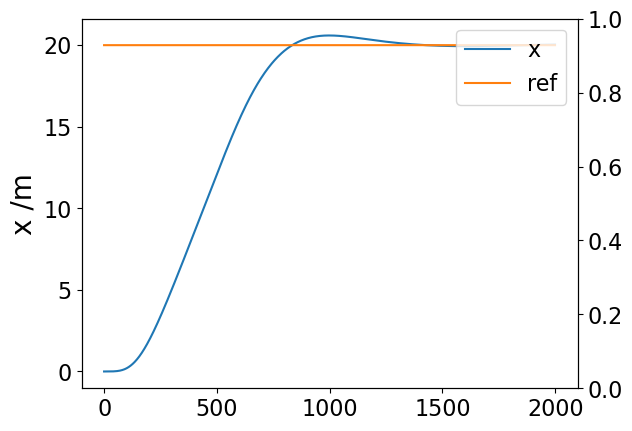

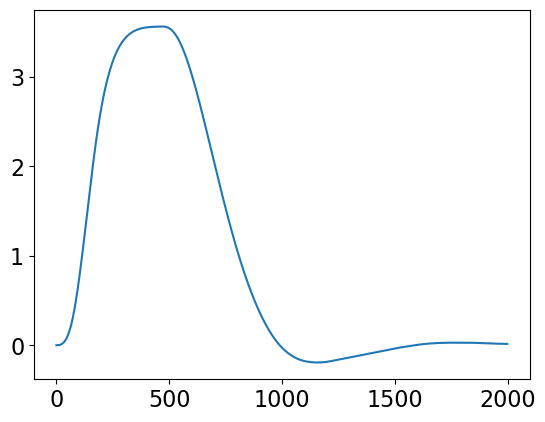

In [355]:
m = Multirotor(vp, sp)
pos = ctrl.ctrl_p
print(pos)
vel = ctrl.ctrl_v
print(vel)
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
log = DataLog(vehicle=m, other_vars=('err', 'torques'))
for i in range(2000):
    ref = np.asarray([20.,20.])
    
    # converting position -> velocity -> angles
    velocity = pos.step(ref, m.position[:2], dt=0.1)
    # ADd the trigonometric change here TODO
#     velocity= np.array([5,0])
    angles = vel.step(velocity, m.velocity[:2], dt=0.1)[::-1]
    # attitude controller operates at higher frequency
    rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
    action = rat.step(rate, m.euler_rate, dt=0.01)
    # clipping torques to prevent over-reactions
    action = np.clip(action, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
    log.log(err=pos.err[0], torques=action)
log.done_logging()

plt.plot(log.x, label='x')
# plt.plot(log.velocity[:,0], label='vel')
plt.plot([ref[0]]*2000, label='ref')
# plt.plot(log.err, label='x-err')
plt.ylabel('x /m')
l = plt.gca().lines
plt.twinx()
# plt.plot(log.torques[:,1], ls=':', label='y-torque', c='c')
# plt.plot(log.pitch * 180 / np.pi, ls='-.', label='Pitch', c='m')
plt.legend(handles=plt.gca().lines+l)
# plt.plot(log.actions[:,0] * 180 / np.pi, ls=':')
plt.show()

plt.plot(log.velocity[:,0], label='vel')

## Defining Trajectories

## Test Experiment

In [456]:
# import pickle
# with open('./params/manual_pid.pkl', 'wb') as file:
#     pickle.dump(ctrl.get_params(), file)